# SnV117 Cyclicity on the Unit Sphere

Calculate cyclicity of transitions between the 4 lowest excited states and 4 lowest ground states.
Sweep B-field direction over the unit sphere and visualize cyclicity as color on 3D spheres.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hamiltonian_qutip as ham
import parameters_qutip as params
%matplotlib inline


In [2]:
# Parameters
# Magnetic field
B_Tesla = 0.3  # [Tesla]
mu_B_GHz_per_T = 13.996  # [GHz/T]
g_e = 2.0
B_GHz = g_e * mu_B_GHz_per_T * B_Tesla  # [GHz]

# Sweep theta and phi on the unit sphere
n_theta = 30  # Number of polar angle points
n_phi = 60    # Number of azimuthal angle points

thetas = np.linspace(0, np.pi, n_theta)
phis = np.linspace(0, 2*np.pi, n_phi)

# Polarization vector for transitions
eta = [1, 0, 1]  # x and z polarization

# Strain parameters
alpha = 200  # [GHz]
beta = 0   # [GHz]

print(f"B = {B_Tesla} T ({B_GHz:.2f} GHz)")
print(f"Sweeping {n_theta} x {n_phi} = {n_theta * n_phi} points on the sphere")


B = 0.3 T (8.40 GHz)
Sweeping 30 x 60 = 1800 points on the sphere


## Calculate Cyclicity Over the Unit Sphere


In [3]:
# Calculate cyclicity for each (theta, phi) point on the sphere
# cyclicity shape: (n_theta, n_phi, 8, 8) - for all 8x8 transitions

cyclicity_sphere = np.zeros((n_theta, n_phi, 8, 8))

# First, determine which states are the 4 lowest at some reference point
# Use theta=0 as reference
E_ref, _, _, _, E_exc_ref, _, _, _, _, _ = ham.PLE_transitions(
    np.array([B_GHz]), 0, 0, eta, alpha=alpha, beta=beta, alpha_exc=0
)
lower_gnd_indices = np.argsort(E_ref[0, :])[:4]
lower_exc_indices = np.argsort(E_exc_ref[0, :])[:4]

print(f"Lower ground state indices: {lower_gnd_indices}")
print(f"Lower excited state indices: {lower_exc_indices}")

# Now sweep over all (theta, phi) points
print("\nCalculating cyclicity over the sphere...")
for i, th in enumerate(thetas):
    if i % 5 == 0:
        print(f"  theta = {th:.2f} rad ({i+1}/{n_theta})")
    for j, ph in enumerate(phis):
        _, _, _, _, _, _, _, _, _, cyc = ham.PLE_transitions(
            np.array([B_GHz]), th, ph, eta, alpha=alpha, beta=beta, alpha_exc=0
        )
        cyclicity_sphere[i, j, :, :] = cyc[0]  # cyc shape is (1, 8, 8)

print("Done!")


Lower ground state indices: [0 1 2 3]
Lower excited state indices: [0 1 2 3]

Calculating cyclicity over the sphere...
  theta = 0.00 rad (1/30)
  theta = 0.54 rad (6/30)
  theta = 1.08 rad (11/30)
  theta = 1.62 rad (16/30)
  theta = 2.17 rad (21/30)
  theta = 2.71 rad (26/30)
Done!


In [4]:
# Extract cyclicity for the 4x4 lower branch transitions
# cyclicity_lower[i, j, exc_idx, gnd_idx] where exc_idx, gnd_idx are 0-3
cyclicity_lower = np.zeros((n_theta, n_phi, 4, 4))

for ei, exc_i in enumerate(lower_exc_indices):
    for gi, gnd_i in enumerate(lower_gnd_indices):
        cyclicity_lower[:, :, ei, gi] = cyclicity_sphere[:, :, exc_i, gnd_i]

# Create mesh for 3D sphere plotting
THETA, PHI = np.meshgrid(thetas, phis, indexing='ij')

# Convert to Cartesian coordinates for plotting
X = np.sin(THETA) * np.cos(PHI)
Y = np.sin(THETA) * np.sin(PHI)
Z = np.cos(THETA)

print(f"Cyclicity lower branch shape: {cyclicity_lower.shape}")
print(f"Mesh shape: {X.shape}")


Cyclicity lower branch shape: (30, 60, 4, 4)
Mesh shape: (30, 60)


### Surface Plot
Cyclicity mapped as colors on smooth sphere surfaces.


C:\Users\56430\AppData\Local\Temp/ipykernel_25108/1426367737.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


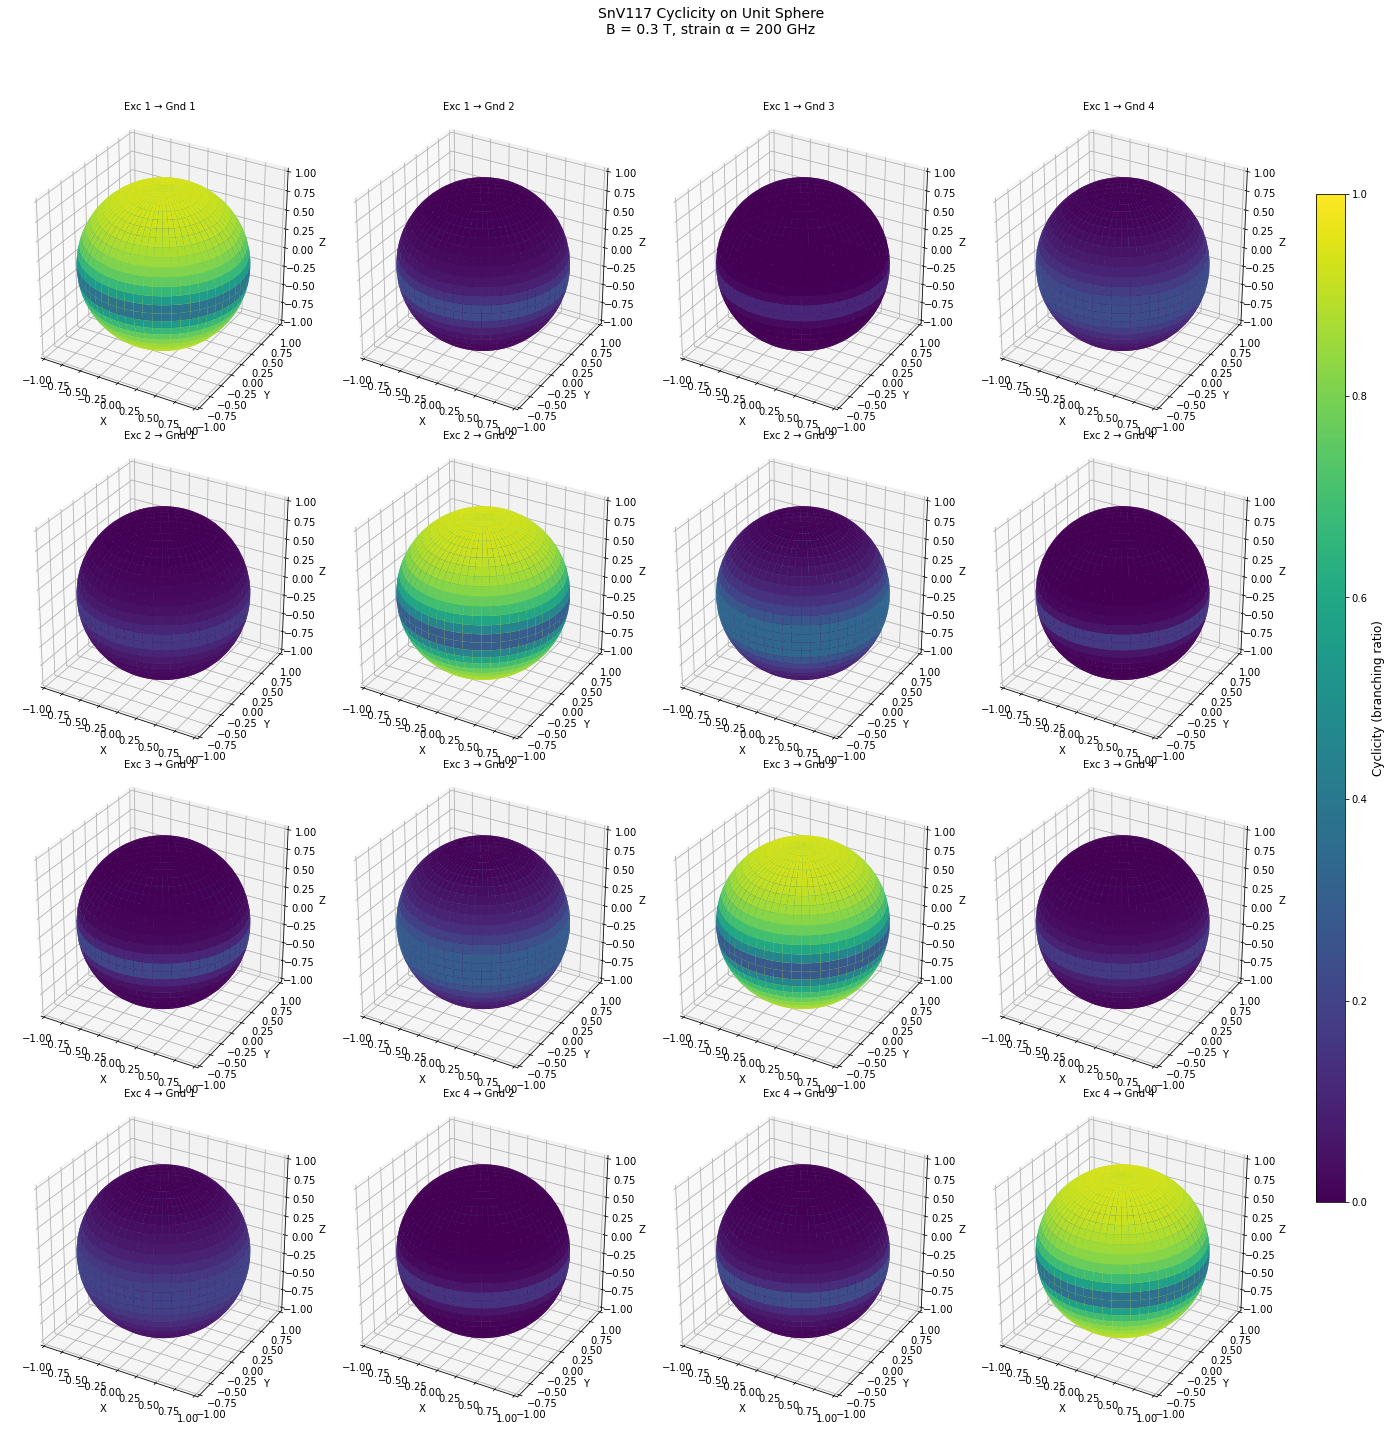


Cyclicity statistics for each transition:
Exc → Gnd | Min    | Max    | Mean
----------------------------------------
1 → 1   | 0.3796 | 0.9428 | 0.8214
1 → 2   | 0.0000 | 0.2242 | 0.0415
1 → 3   | 0.0001 | 0.1063 | 0.0101
1 → 4   | 0.0000 | 0.2339 | 0.0709
2 → 1   | 0.0000 | 0.1594 | 0.0309
2 → 2   | 0.2892 | 0.9440 | 0.7919
2 → 3   | 0.0000 | 0.3308 | 0.1040
2 → 4   | 0.0000 | 0.1645 | 0.0172
3 → 1   | 0.0012 | 0.2110 | 0.0289
3 → 2   | 0.0000 | 0.2889 | 0.0952
3 → 3   | 0.2747 | 0.9426 | 0.7919
3 → 4   | 0.0000 | 0.1698 | 0.0279
4 → 1   | 0.0000 | 0.1976 | 0.0641
4 → 2   | 0.0000 | 0.1456 | 0.0167
4 → 3   | 0.0000 | 0.2288 | 0.0364
4 → 4   | 0.3720 | 0.9438 | 0.8266


In [5]:
# Plot 16 spheres (4 excited x 4 ground) in a 4x4 grid
fig = plt.figure(figsize=(20, 20))

# Use a colormap
cmap = plt.cm.viridis

for ei in range(4):
    for gi in range(4):
        ax = fig.add_subplot(4, 4, ei * 4 + gi + 1, projection='3d')
        
        # Get cyclicity for this transition
        cyc = cyclicity_lower[:, :, ei, gi]
        
        # Normalize colors
        norm = plt.Normalize(vmin=0, vmax=1)
        colors = cmap(norm(cyc))
        
        # Plot the surface
        surf = ax.plot_surface(X, Y, Z, facecolors=colors, 
                               rstride=1, cstride=1, 
                               linewidth=0, antialiased=True,
                               shade=False)
        
        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Exc {lower_exc_indices[ei]+1} → Gnd {lower_gnd_indices[gi]+1}', fontsize=10)
        
        # Set equal aspect ratio
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_box_aspect([1, 1, 1])

# Add a colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Cyclicity (branching ratio)', fontsize=12)

fig.suptitle(f'SnV117 Cyclicity on Unit Sphere\nB = {B_Tesla} T, strain α = {alpha} GHz', 
             fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# Print some statistics
print("\nCyclicity statistics for each transition:")
print("Exc → Gnd | Min    | Max    | Mean")
print("-" * 40)
for ei in range(4):
    for gi in range(4):
        cyc = cyclicity_lower[:, :, ei, gi]
        print(f"{lower_exc_indices[ei]+1} → {lower_gnd_indices[gi]+1}   | {cyc.min():.4f} | {cyc.max():.4f} | {cyc.mean():.4f}")


### Scatter Plot
Individual points on the sphere - better for seeing angular dependence.


C:\Users\56430\AppData\Local\Temp/ipykernel_25108/348517170.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


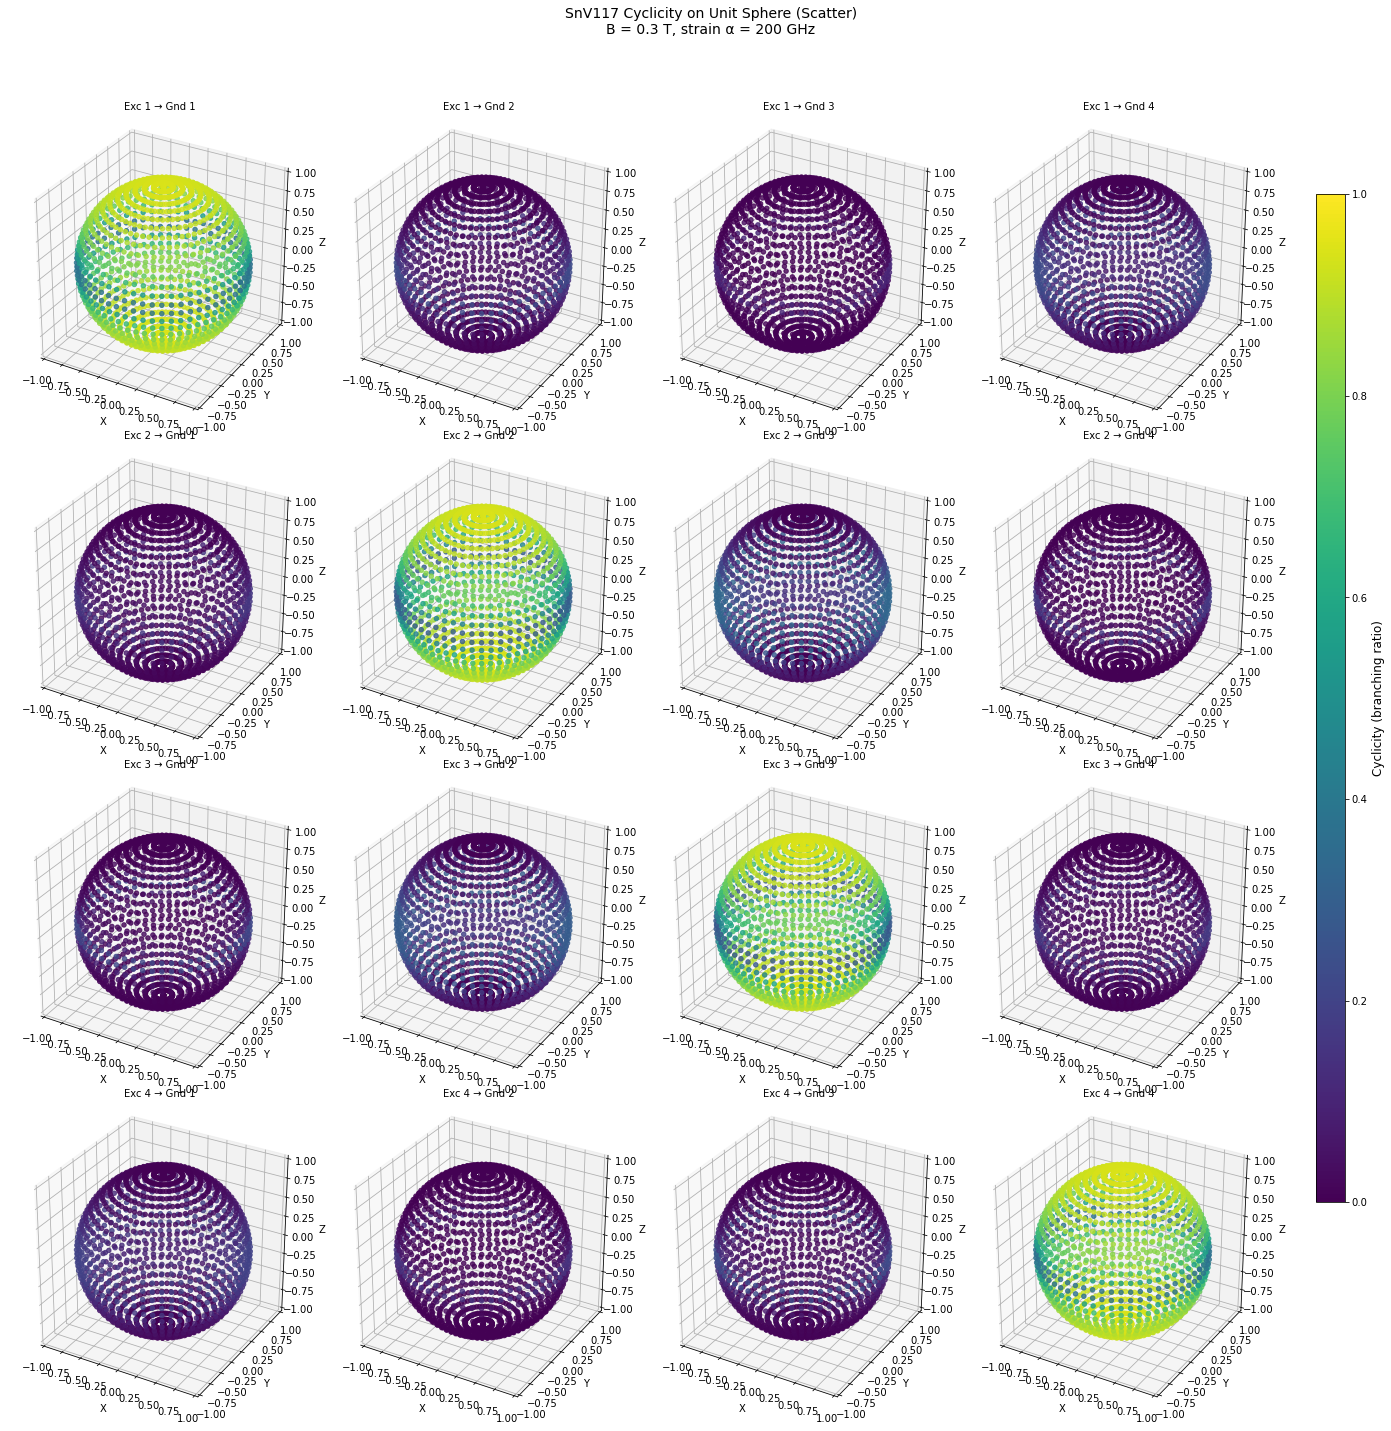

In [6]:
# Alternative: Plot with scatter points for better visibility
fig = plt.figure(figsize=(20, 20))

for ei in range(4):
    for gi in range(4):
        ax = fig.add_subplot(4, 4, ei * 4 + gi + 1, projection='3d')
        
        # Get cyclicity for this transition
        cyc = cyclicity_lower[:, :, ei, gi]
        
        # Flatten for scatter plot
        x_flat = X.flatten()
        y_flat = Y.flatten()
        z_flat = Z.flatten()
        c_flat = cyc.flatten()
        
        # Plot scatter
        scatter = ax.scatter(x_flat, y_flat, z_flat, c=c_flat, 
                            cmap='viridis', vmin=0, vmax=1, 
                            s=20, alpha=0.8)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Exc {lower_exc_indices[ei]+1} → Gnd {lower_gnd_indices[gi]+1}', fontsize=10)
        
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_box_aspect([1, 1, 1])

# Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Cyclicity (branching ratio)', fontsize=12)

fig.suptitle(f'SnV117 Cyclicity on Unit Sphere (Scatter)\nB = {B_Tesla} T, strain α = {alpha} GHz', 
             fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()
